In [7]:
%matplotlib inline

In [8]:
from collections import defaultdict

In [95]:
import numpy as np
import pandas as pd
from scipy.stats import gmean
from skimage.morphology import remove_small_holes, remove_small_objects

In [10]:
import matplotlib.pyplot as plt

In [11]:
import config
from utils.io import load_pickle
from utils.torch.datasets import PathologicalImagesDataset, PathologicalImagesDatasetMode
from utils.scoring import topcoder_metric
from utils.plotting import plot_image_and_mask
from utils.postprocessing import morph_masks
from predict import get_prediction_filename

# Load data

In [152]:
nb_folds = 5
fold_number = 0
model_name = 'unet_ds'
patch_size_train = 0
patch_size_predict = 0
use_dice = False
use_tta = True

In [153]:
average_mode = 'gmean'

In [154]:
mode = PathologicalImagesDatasetMode.All
base_dir = config.DATASET_TEST_DIR

In [155]:
dataset = PathologicalImagesDataset(base_dir, mode=mode, nb_folds=nb_folds, fold_number=fold_number)

In [156]:
images = [dataset[i][0] for i in range(len(dataset))]
images = np.stack(images)

In [157]:
masks = [dataset[i][1] for i in range(len(dataset))]
masks = np.stack(masks)

In [158]:
images.shape, masks.shape

((162, 500, 500, 3), (162,))

In [159]:
predictions = defaultdict(list)

for fold_number in range(nb_folds):
    predictions_filename = get_prediction_filename(model_name, mode, patch_size_train, patch_size_predict,
                                                   fold_number, use_dice, use_tta)
    images_names, fold_predictions = load_pickle(predictions_filename)

    for image, image_pred in zip(images_names, fold_predictions):
        predictions[image].append(image_pred)

if average_mode == 'gmean':
    predictions = [gmean(predictions[image]) for image in images_names]
elif average_mode == 'mean':
    predictions = [np.mean(predictions[image], axis=0) for image in images_names]
else:
    ValueError(f'Average mode {average_mode} unknown')

In [160]:
predictions = np.stack(predictions, axis=0)

In [161]:
threshold = 0.3

In [162]:
predictions_masks = np.zeros_like(predictions, dtype=np.uint8)
predictions_masks[predictions>threshold] = 1

In [163]:
predictions_masks.shape

(162, 500, 500)

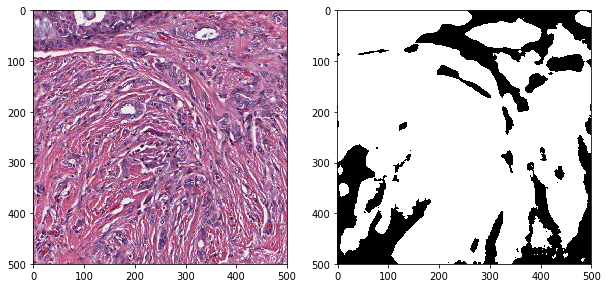

In [164]:
i = 1
plot_image_and_mask(images[i], predictions_masks[i])
# plot_image_and_mask(images[i], morph_masks(predictions_masks[i], kernel_size=11, operation='open'))

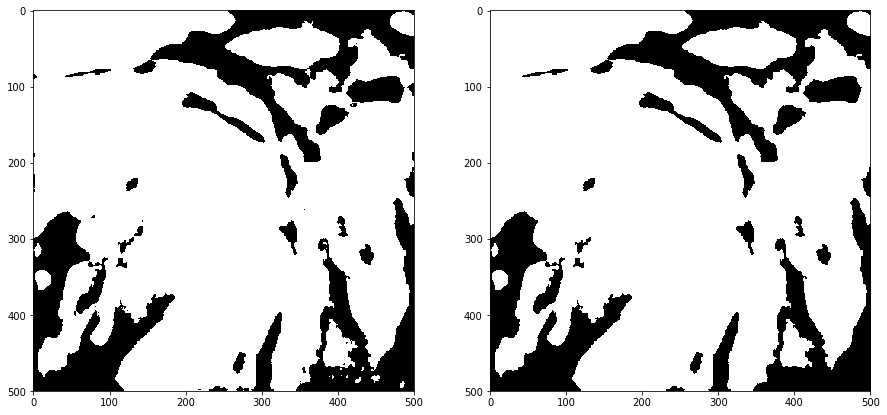

In [166]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
ax1.imshow(predictions_masks[i], cmap='gray')
ax2.imshow(remove_small_holes(remove_small_objects(predictions_masks[i].astype(np.bool), 110), 110), cmap='gray')